In [1]:
from feast import FeatureStore
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from joblib import dump
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from joblib import load

In [2]:
# Getting our FeatureStore
store = FeatureStore(repo_path=".")

In [3]:
# Retrieving the saved dataset and converting it to a DataFrame
training_df = store.get_saved_dataset(name="churn_dataset").to_df()

C:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\feast\feature_store.py:1178: RuntimeWarning: Retrieving datasets is an experimental feature. This API is unstable and it could and most probably will be changed in the future. We do not guarantee that future changes will maintain backward compatibility.
  warnings.warn(


In [4]:
training_df

,USER_ID,Geography_Spain,Geography_Germany,Gender,event_timestamp,Geography_France,CreditScore,Tenure,NumOfProducts,EstimatedSalary,Age,Exited,IsActiveMember,Balance,HasCrCard
0,9417,False,True,1,2023-01-01 00:00:00+00:00,False,648,6,1,86894.67,37,0,0,131753.41,1
1,6186,False,True,1,2023-01-01 00:00:00+00:00,False,699,6,1,33687.90,36,0,1,147137.74,1
2,792,False,False,1,2023-01-01 00:00:00+00:00,True,611,3,2,142917.54,49,0,1,0.00,1
3,9133,False,False,0,2023-01-01 00:00:00+00:00,True,635,5,2,122949.71,33,0,0,0.00,1
4,9145,False,True,1,2023-01-01 00:00:00+00:00,False,818,10,1,78941.59,43,0,1,105301.50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9329,False,True,0,2023-12-31 00:00:00+00:00,False,540,7,2,198256.15,35,0,0,128369.75,1
9996,7324,True,False,1,2023-12-31 00:00:00+00:00,False,742,8,2,4070.28,24,0,0,0.00,1
9997,7966,False,False,0,2023-12-31 00:00:00+00:00,True,625,4,2,92243.94,51,1,0,124620.01,1
9998,5255,True,False,1,2023-12-31 00:00:00+00:00,False,463,8,1,128268.39,20,0,0,204223.03,1


In [5]:
# Separating the features and labels
labels = training_df['Exited']
features = training_df.drop(
    labels=['Exited', 'event_timestamp', 'USER_ID'],
    axis=1)

In [6]:
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    stratify=labels)

In [7]:
columns_order = load('columns_order.joblib')
columns_order

Index(['Geography_Spain', 'HasCrCard', 'Balance', 'Age', 'Gender', 'Tenure',
       'EstimatedSalary', 'CreditScore', 'NumOfProducts', 'Geography_France',
       'IsActiveMember', 'Geography_Germany'],
      dtype='object')

In [8]:
# Riorganizza le colonne di X_test in base all'ordine delle colonne utilizzate durante l'addestramento
X_test = X_test[columns_order]
X_train = X_train[columns_order]

### Train 2 - Logistic Regression Classifier

In [9]:
# Define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300]
}

In [10]:
# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to your data
grid_search.fit(X=X_train, y=y_train)

C:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100], 'max_iter': [100, 200, 300],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [11]:
# Supponiamo che queste siano le colonne usate durante l'addestramento
columns_order = X_train.columns

# Salva l'ordine delle colonne in un file di testo
with open("columns_order2.txt", "w") as file:
    for column in columns_order:
        file.write(f"{column}\n")

In [12]:
columns_order

Index(['Geography_Spain', 'HasCrCard', 'Balance', 'Age', 'Gender', 'Tenure',
       'EstimatedSalary', 'CreditScore', 'NumOfProducts', 'Geography_France',
       'IsActiveMember', 'Geography_Germany'],
      dtype='object')

In [13]:
# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters: ", best_params)
print("Best Estimator: ", best_estimator)

Best Parameters:  {'C': 0.1, 'max_iter': 300, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Estimator:  LogisticRegression(C=0.1, max_iter=300)


In [14]:
# Make predictions and evaluate your model
y_pred = best_estimator.predict(X_test)

In [15]:
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: ", accuracy)

Test Accuracy:  0.8084


In [16]:
# Saving the model
dump(value=grid_search, filename="logistic_regression.joblib")

['logistic_regression.joblib']

### Confronto tra i due modelli

In [17]:
# Load random forest model
model = load('random_forest_model.joblib')

In [18]:
y_pred_prob_1 = model.predict_proba(X_test)[:, 1]

In [19]:
y_pred_prob_2 = grid_search.predict_proba(X_test)[:,-1]

In [20]:
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_pred_prob_1)
auc_1 = roc_auc_score(y_test, y_pred_prob_1)

In [21]:
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_pred_prob_2)
auc_2 = roc_auc_score(y_test, y_pred_prob_2)

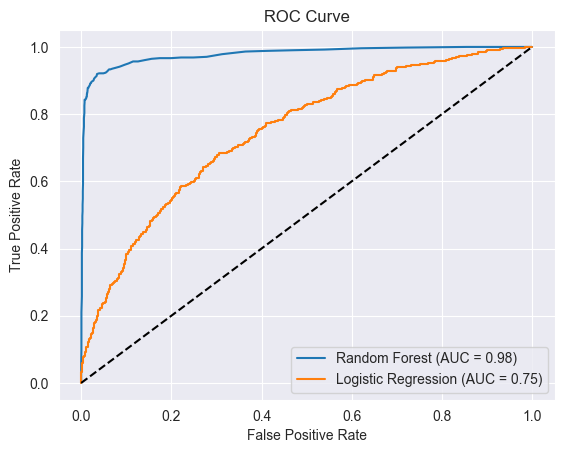

In [22]:
plt.plot(fpr_1, tpr_1, label=f'Random Forest (AUC = {auc_1:.2f})')
plt.plot(fpr_2, tpr_2, label=f'Logistic Regression (AUC = {auc_2:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()